In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

# copy the .zip file into the root directory of cloud VM
!cp /content/gdrive/MyDrive/dataset.zip ../

# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ../dataset.zip

'Colab Notebooks'   dataset.zip  'My Drive'
Archive:  ../dataset.zip
   creating: dataset/
  inflating: dataset/testdata_10.csv  
  inflating: dataset/testdata_20.csv  
  inflating: dataset/testdata_30.csv  
  inflating: dataset/testdata_40.csv  
  inflating: dataset/testdata_50.csv  
  inflating: dataset/traindata_50.csv  
  inflating: dataset/traindata_60.csv  
  inflating: dataset/traindata_70.csv  
  inflating: dataset/traindata_80.csv  
  inflating: dataset/traindata_90.csv  


In [ ]:
from __future__ import print_function
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.datasets import imdb
from keras.utils.np_utils import to_categorical
from sklearn.metrics import (precision_score, recall_score,f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [ ]:
traindata = pd.read_csv('dataset/traindata_50.csv')
testdata = pd.read_csv('dataset/testdata_50.csv')

In [ ]:
traindata.drop(['Unnamed: 0','Timestamp'], axis = 1, inplace=True)
testdata.drop(['Unnamed: 0','Timestamp'], axis = 1, inplace=True)

In [ ]:
traindata = traindata.replace(to_replace = ["DDOS attack-HOIC"],value = 1)
traindata = traindata.replace(to_replace = ["Benign"],value = 0)
testdata = testdata.replace(to_replace = ["DDOS attack-HOIC"],value = 1)
testdata = testdata.replace(to_replace = ["Benign"],value = 0)

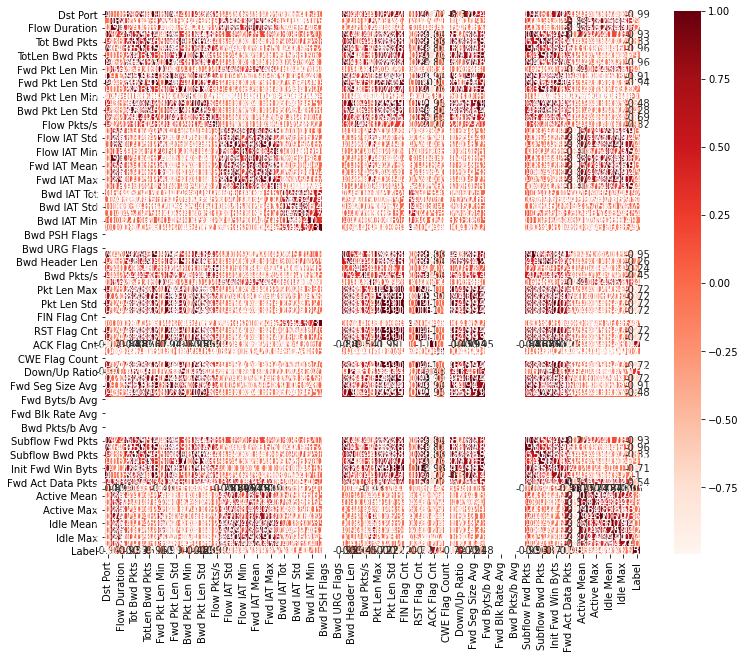

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor1 = traindata.corr()
sns.heatmap(cor1, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
a = abs(cor1['Label'])
result = a[a > 0.1]
result

Dst Port             0.990309
Tot Fwd Pkts         0.928242
Tot Bwd Pkts         0.332358
TotLen Fwd Pkts      0.963077
TotLen Bwd Pkts      0.110003
Fwd Pkt Len Max      0.964790
Fwd Pkt Len Mean     0.907802
Fwd Pkt Len Std      0.942623
Bwd Pkt Len Max      0.109875
Bwd Pkt Len Mean     0.478382
Bwd Pkt Len Std      0.279612
Flow Byts/s          0.687545
Flow Pkts/s          0.320317
Bwd IAT Min          0.106296
Fwd Header Len       0.946162
Bwd Header Len       0.256283
Fwd Pkts/s           0.244122
Bwd Pkts/s           0.446099
Pkt Len Max          0.719146
Pkt Len Mean         0.718912
Pkt Len Std          0.718361
Pkt Len Var          0.718267
RST Flag Cnt         0.718132
PSH Flag Cnt         0.718821
ACK Flag Cnt         0.724065
ECE Flag Cnt         0.718132
Down/Up Ratio        0.311208
Pkt Size Avg         0.718623
Fwd Seg Size Avg     0.907802
Bwd Seg Size Avg     0.478382
Subflow Fwd Pkts     0.928242
Subflow Fwd Byts     0.963077
Subflow Bwd Pkts     0.332358
Subflow Bw

In [ ]:
traindata.drop(['Protocol','Flow Byts/s','Flow Pkts/s','Pkt Len Min','Fwd Byts/b Avg','Fwd Pkts/b Avg','Fwd Blk Rate Avg','Bwd Byts/b Avg','Bwd Pkts/b Avg','Bwd Blk Rate Avg','Fwd Seg Size Min','Active Mean','Active Std','Active Max','Active Min','Idle Mean','Idle Std','Idle Max','Idle Min','FIN Flag Cnt','SYN Flag Cnt','URG Flag Cnt','CWE Flag Count','Flow Duration'], axis = 1, inplace=True)
testdata.drop(['Protocol','Flow Byts/s','Flow Pkts/s','Pkt Len Min','Fwd Byts/b Avg','Fwd Pkts/b Avg','Fwd Blk Rate Avg','Bwd Byts/b Avg','Bwd Pkts/b Avg','Bwd Blk Rate Avg','Fwd Seg Size Min','Active Mean','Active Std','Active Max','Active Min','Idle Mean','Idle Std','Idle Max','Idle Min','FIN Flag Cnt','SYN Flag Cnt','URG Flag Cnt','CWE Flag Count','Flow Duration'], axis = 1, inplace=True)

In [ ]:
enc = LabelEncoder()
traindata = traindata.apply(enc.fit_transform)
testdata = testdata.apply(enc.fit_transform)

In [ ]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523422 entries, 0 to 523421
Data columns (total 55 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Dst Port           523422 non-null  int64
 1   Tot Fwd Pkts       523422 non-null  int64
 2   Tot Bwd Pkts       523422 non-null  int64
 3   TotLen Fwd Pkts    523422 non-null  int64
 4   TotLen Bwd Pkts    523422 non-null  int64
 5   Fwd Pkt Len Max    523422 non-null  int64
 6   Fwd Pkt Len Min    523422 non-null  int64
 7   Fwd Pkt Len Mean   523422 non-null  int64
 8   Fwd Pkt Len Std    523422 non-null  int64
 9   Bwd Pkt Len Max    523422 non-null  int64
 10  Bwd Pkt Len Min    523422 non-null  int64
 11  Bwd Pkt Len Mean   523422 non-null  int64
 12  Bwd Pkt Len Std    523422 non-null  int64
 13  Flow IAT Mean      523422 non-null  int64
 14  Flow IAT Std       523422 non-null  int64
 15  Flow IAT Max       523422 non-null  int64
 16  Flow IAT Min       523422 non-null  in

In [ ]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523422 entries, 0 to 523421
Data columns (total 55 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Dst Port           523422 non-null  int64
 1   Tot Fwd Pkts       523422 non-null  int64
 2   Tot Bwd Pkts       523422 non-null  int64
 3   TotLen Fwd Pkts    523422 non-null  int64
 4   TotLen Bwd Pkts    523422 non-null  int64
 5   Fwd Pkt Len Max    523422 non-null  int64
 6   Fwd Pkt Len Min    523422 non-null  int64
 7   Fwd Pkt Len Mean   523422 non-null  int64
 8   Fwd Pkt Len Std    523422 non-null  int64
 9   Bwd Pkt Len Max    523422 non-null  int64
 10  Bwd Pkt Len Min    523422 non-null  int64
 11  Bwd Pkt Len Mean   523422 non-null  int64
 12  Bwd Pkt Len Std    523422 non-null  int64
 13  Flow IAT Mean      523422 non-null  int64
 14  Flow IAT Std       523422 non-null  int64
 15  Flow IAT Max       523422 non-null  int64
 16  Flow IAT Min       523422 non-null  in

In [ ]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523422 entries, 0 to 523421
Data columns (total 55 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Dst Port           523422 non-null  int64
 1   Tot Fwd Pkts       523422 non-null  int64
 2   Tot Bwd Pkts       523422 non-null  int64
 3   TotLen Fwd Pkts    523422 non-null  int64
 4   TotLen Bwd Pkts    523422 non-null  int64
 5   Fwd Pkt Len Max    523422 non-null  int64
 6   Fwd Pkt Len Min    523422 non-null  int64
 7   Fwd Pkt Len Mean   523422 non-null  int64
 8   Fwd Pkt Len Std    523422 non-null  int64
 9   Bwd Pkt Len Max    523422 non-null  int64
 10  Bwd Pkt Len Min    523422 non-null  int64
 11  Bwd Pkt Len Mean   523422 non-null  int64
 12  Bwd Pkt Len Std    523422 non-null  int64
 13  Flow IAT Mean      523422 non-null  int64
 14  Flow IAT Std       523422 non-null  int64
 15  Flow IAT Max       523422 non-null  int64
 16  Flow IAT Min       523422 non-null  in

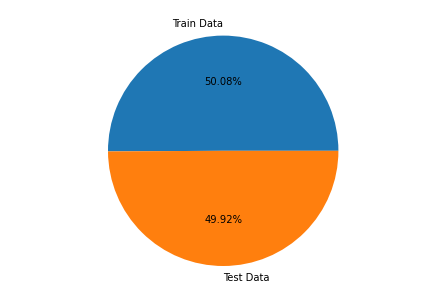

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
data = ['Train Data','Test Data']
Label = [524287,522557]
ax.pie(Label,labels=data,autopct='%1.2f%%')
plt.show()

In [ ]:
traindata.groupby('Label')['Label'].count()

Label
0    180622
1    342800
Name: Label, dtype: int64

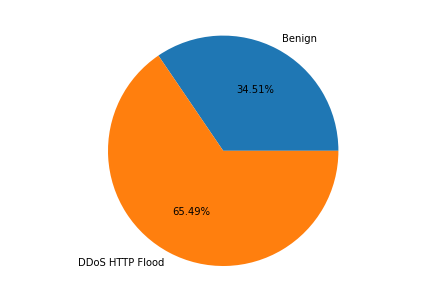

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
data = ['Benign','DDoS HTTP Flood']
Label = [180930,343357]
ax.pie(Label,labels=data,autopct='%1.2f%%')
plt.show()

In [ ]:
testdata.groupby('Label')['Label'].count()

Label
0    180210
1    343212
Name: Label, dtype: int64

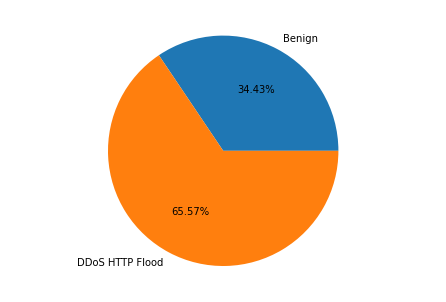

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
data = ['Benign','DDoS HTTP Flood']
Label = [179903,342654]
ax.pie(Label,labels=data,autopct='%1.2f%%')
plt.show()

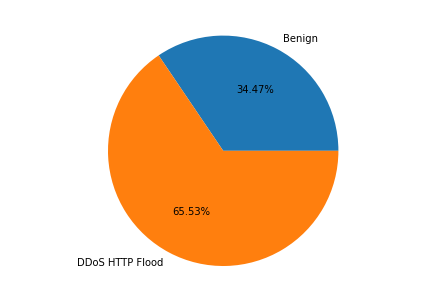

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
data = ['Benign','DDoS HTTP Flood']
Label = [360833,686012]
ax.pie(Label,labels=data,autopct='%1.2f%%')
plt.show()

In [ ]:
X = traindata.iloc[:, 0:53]
Y = traindata.iloc[:, 54]
C = testdata.iloc[:, 54]
T = testdata.iloc[:, 0:53]

In [ ]:
scaler = Normalizer().fit(X)
trainX = scaler.transform(X)

In [ ]:
scaler = Normalizer().fit(T)
testT = scaler.transform(T)

In [ ]:
y_train = np.array(Y)
y_test = np.array(C)

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testT, (testT.shape[0], 1, testT.shape[1]))

In [ ]:
print(X_train.shape)

(523422, 1, 53)


In [ ]:
batch_size = 64

In [ ]:
model = Sequential()
model.add(LSTM(16,input_dim=53, return_sequences=True))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(LSTM(8, return_sequences=False))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))
print(model.get_config())

{'name': 'sequential', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, None, 53), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'lstm_input'}}, {'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'batch_input_shape': (None, None, 53), 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 16, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropou

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 16)          4480      
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 5,289
Trainable params: 5,289
Non-trainable params: 0
______________________________________________________

In [ ]:
import keras
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.SGD(learning_rate=0.001),metrics=['accuracy'])
csv_logger = CSVLogger('training_set_iranalysis.csv',separator=',', append=False)
lstm_model = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test),callbacks=[csv_logger])
model.save("kddresults/lstm/fullmodel/lstm_model.hdf5")

Epoch 1/100
8179/8179 [==============================] - 83s 6ms/step - loss: 0.6668 - accuracy: 0.6422 - val_loss: 0.6418 - val_accuracy: 0.6557
Epoch 2/100
8179/8179 [==============================] - 49s 6ms/step - loss: 0.6416 - accuracy: 0.6548 - val_loss: 0.6391 - val_accuracy: 0.6557
Epoch 3/100
8179/8179 [==============================] - 49s 6ms/step - loss: 0.6386 - accuracy: 0.6555 - val_loss: 0.6365 - val_accuracy: 0.6557
Epoch 4/100
8179/8179 [==============================] - 49s 6ms/step - loss: 0.6355 - accuracy: 0.6560 - val_loss: 0.6331 - val_accuracy: 0.6557
Epoch 5/100
8179/8179 [==============================] - 49s 6ms/step - loss: 0.6316 - accuracy: 0.6564 - val_loss: 0.6283 - val_accuracy: 0.6557
Epoch 6/100
8179/8179 [==============================] - 49s 6ms/step - loss: 0.6281 - accuracy: 0.6535 - val_loss: 0.6211 - val_accuracy: 0.6557
Epoch 7/100
8179/8179 [==============================] - 49s 6ms/step - loss: 0.6195 - accuracy: 0.6545 - val_loss: 0.6096 -

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.4f, Accuracy: %.4f%%" % (loss, accuracy*100))
lstm_predict = model.predict_classes(X_test)

16357/16357 [==============================] - 36s 2ms/step - loss: 0.0034 - accuracy: 0.9996

Loss: 0.0034, Accuracy: 99.9641%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


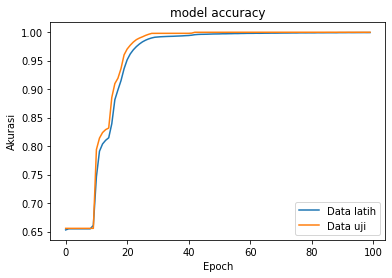

In [ ]:
plt.plot(lstm_model.history['accuracy'])
plt.plot(lstm_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Data latih', 'Data uji'], loc='lower right')
plt.show()

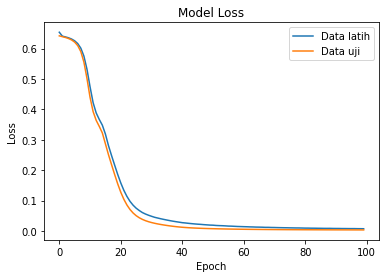

In [ ]:
plt.plot(lstm_model.history['loss'])
plt.plot(lstm_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Data latih', 'Data uji'], loc='upper right')
plt.show()

In [ ]:
cm = confusion_matrix(y_test, lstm_predict)
print(cm)
tp = cm[0,0]
tn = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]

[[180029    181]
 [     7 343205]]


In [ ]:
precision = tp / ( tp + fp)
recall = tp/(tp+fn)
f1=(2*precision*recall)/ (precision+recall)
akurasi = (tp+tn)/(tp+tn+fp+fn)
Sensitivity = tp/(tp + fn)

In [ ]:
print ("precesion : ",precision)
print("recall : ",recall)
print ("F1 : ",f1)
print("sensitivity : ",Sensitivity )
print("akurasi : ",akurasi)

precesion :  0.9989956162255147
recall :  0.9999611188873336
F1 :  0.9994781343859473
sensitivity :  0.9999611188873336
akurasi :  0.9996408251850324


<function matplotlib.pyplot.show>

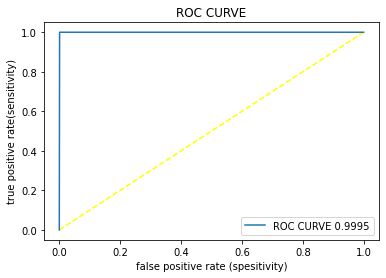

In [ ]:
import keras
import seaborn as sns
from sklearn.metrics import roc_curve, auc

fpr_keras,tpr_keras, threshold =roc_curve(y_test, lstm_predict)
auc=auc(fpr_keras,tpr_keras)

plt.figure(1)
plt.plot([0,1],[0,1],'k--',color='yellow')
plt.plot(fpr_keras, tpr_keras, label="ROC CURVE {0:.4f}".format(auc))
plt.xlabel('false positive rate (spesitivity)')
plt.ylabel('true positive rate(sensitivity)')
plt.title('ROC CURVE')
plt.legend(loc='best')
plt.show

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, lstm_predict)

print('Average precision-recall score: {0:0.8f}'.format(
      average_precision))

Average precision-recall score: 0.99946589


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.99946589')

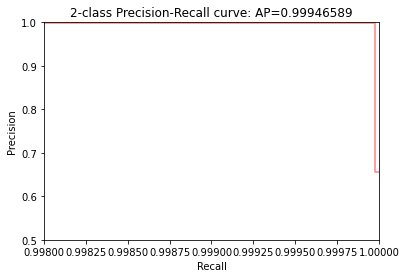

In [ ]:
from inspect import signature
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test, lstm_predict)
average_precision = average_precision_score(y_test, lstm_predict)
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall, precision, color='r', alpha=0.5, where='post')
plt.fill_between(recall, precision, alpha=0.5, color='w', **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.5000, 1.0000])
plt.xlim([0.9980, 1.0000])
plt.title('2-class Precision-Recall curve: AP={0:0.8f}'.format(average_precision))

In [ ]:
lstm_predict

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [ ]:
import pandas as pd
import numpy as np
lstm_predict.shape

(523422, 1)

In [ ]:
type(lstm_predict)

numpy.ndarray

In [ ]:
dataset = pd.DataFrame()
dataset['lstm_predict'] = lstm_predict.tolist()

In [ ]:
dataset.head()

,lstm_predict
0,[1]
1,[1]
2,[1]
3,[1]
4,[1]


In [ ]:
hasil = pd.concat([testdata,dataset], axis=1)

In [ ]:
hasil

,Dst Port,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Label,lstm_predict
0,4,2,4,57,54,53,0,61,62,53,0,62,62,8417,159287,8128,4,8413,15212,126334,8134,295,8950,7899,34257,8490,25,0,0,0,0,12,7,49357,31606,11,70,70,70,1,1,0,1,1,95,61,62,2,57,4,54,40,4,1,1,[1]
1,4,1,0,0,0,0,0,0,0,0,0,0,0,32120,0,6773,6746,6739,22559,0,6779,6892,0,0,0,0,0,0,0,0,0,6,0,45944,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]
2,4,1,0,0,0,0,0,0,0,0,0,0,0,4720,0,753,726,719,2973,0,759,872,0,0,0,0,0,0,0,0,0,6,0,67283,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]
3,4,1,0,0,0,0,0,0,0,0,0,0,0,7909,0,1285,1258,1251,4968,0,1291,1404,0,0,0,0,0,0,0,0,0,6,0,65172,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]
4,4,1,0,0,0,0,0,0,0,0,0,0,0,8256,0,1343,1316,1309,5191,0,1349,1462,0,0,0,0,0,0,0,0,0,6,0,64949,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523417,11054,4,2,80,30,66,0,74,76,29,0,36,31,747,86103,675,5,1194,763,70451,993,6,770,1738,0,770,809,0,0,0,0,22,4,68601,37627,11,55,55,55,1,1,0,1,0,79,74,36,4,80,2,30,40,19,1,0,[0]
523418,4,1,0,0,0,0,0,0,0,0,0,0,0,24376,0,4413,4386,4379,16255,0,4419,4532,0,0,0,0,0,0,0,0,0,6,0,54088,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]
523419,4,1,0,0,0,0,0,0,0,0,0,0,0,7675,0,1246,1219,1212,4815,0,1252,1365,0,0,0,0,0,0,0,0,0,6,0,65322,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]
523420,4,1,0,0,0,0,0,0,0,0,0,0,0,44528,0,17005,16885,16971,39377,0,17010,17031,0,0,0,0,0,0,0,0,0,6,0,21034,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,[1]


In [ ]:
hasil.to_csv(r'validasi_50_50.csv')

In [ ]:
hasil = pd.read_csv('validasi_50_50.csv')

In [ ]:
data = hasil.replace(to_replace = ["[1]"],value = 1)
data = data.replace(to_replace = ["[0]"],value = 0)

In [ ]:
data.head(20)

,Unnamed: 0,Dst Port,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Label,lstm_predict
0,0,4,2,4,57,54,53,0,61,62,53,0,62,62,8417,159287,8128,4,8413,15212,126334,8134,295,8950,7899,34257,8490,25,0,0,0,0,12,7,49357,31606,11,70,70,70,1,1,0,1,1,95,61,62,2,57,4,54,40,4,1,1,1
1,1,4,1,0,0,0,0,0,0,0,0,0,0,0,32120,0,6773,6746,6739,22559,0,6779,6892,0,0,0,0,0,0,0,0,0,6,0,45944,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,1
2,2,4,1,0,0,0,0,0,0,0,0,0,0,0,4720,0,753,726,719,2973,0,759,872,0,0,0,0,0,0,0,0,0,6,0,67283,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,1
3,3,4,1,0,0,0,0,0,0,0,0,0,0,0,7909,0,1285,1258,1251,4968,0,1291,1404,0,0,0,0,0,0,0,0,0,6,0,65172,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,1
4,4,4,1,0,0,0,0,0,0,0,0,0,0,0,8256,0,1343,1316,1309,5191,0,1349,1462,0,0,0,0,0,0,0,0,0,6,0,64949,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,32,0,0,1,1
5,5,4,2,4,19,54,15,0,20,18,53,0,62,62,2206,119732,1959,5,2271,4214,99008,1965,322,2773,2053,13506,2411,34,0,0,0,0,12,7,63511,37549,11,33,33,33,1,1,0,1,1,57,20,62,2,19,4,54,40,4,1,1,1
6,6,1532,4,2,80,46,66,0,74,76,45,0,53,47,4084,130243,3984,2,4558,4064,106120,4307,3,4047,11150,0,4040,3980,0,0,0,0,22,4,63486,31220,11,70,70,70,1,1,0,1,0,95,74,53,4,80,2,46,40,19,1,0,0
7,7,3719,4,2,80,16,66,0,74,76,15,0,21,17,748,84798,662,5,1195,764,72269,1003,6,757,1707,0,757,796,0,0,0,0,22,4,68600,37625,11,39,39,39,1,1,0,1,0,63,74,21,4,80,2,16,40,19,1,0,0
8,8,6462,4,2,80,46,66,0,74,76,45,0,53,47,15635,215717,15655,5,16153,14362,146142,15937,6,15640,30810,0,15685,12981,0,0,0,0,22,4,47460,12962,11,70,70,70,1,1,0,1,0,95,74,53,4,80,2,46,40,19,1,0,0
9,9,3874,4,2,80,27,66,0,74,76,26,0,33,28,598,44305,527,2,1045,614,32340,822,3,622,1337,0,622,661,0,0,0,0,22,4,68787,37885,11,51,51,51,1,1,0,1,0,75,74,33,4,80,2,27,40,19,1,0,0


In [ ]:
data_attack = data[data["Label"]==1]
data_normal = data[data["Label"]==0]

In [ ]:
attack_error = data_attack[data_attack.loc[:,"Label"] != data_attack.loc[:,"lstm_predict"]]
normal_error = data_normal[data_normal.loc[:,"Label"] != data_normal.loc[:,"lstm_predict"]]

In [ ]:
attack_error

,Unnamed: 0,Dst Port,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Label,lstm_predict
76559,76559,4,2,4,42,54,38,0,46,46,53,0,62,62,3985,119368,1656,2,1884,3495,96811,1662,238,4529,3561,5755,2016,1011,0,0,0,0,12,7,59206,35977,11,56,56,56,1,1,0,1,1,81,46,62,2,42,4,54,40,4,1,1,0
220317,220317,4,2,4,37,54,33,0,41,37,53,0,62,62,617,94258,725,6,824,1394,69593,738,105,1186,568,5522,954,26,0,0,0,0,12,7,67557,39053,11,51,51,51,1,1,0,1,1,75,41,62,2,37,4,54,40,4,1,1,0
236085,236085,4,2,4,13,54,10,0,13,12,53,0,62,62,426,42802,437,3,425,596,10644,450,15,995,377,62,551,22,0,0,0,0,12,7,68067,39244,11,28,28,28,1,1,0,1,1,52,13,62,2,13,4,54,40,4,1,1,0
360426,360426,4,2,4,19,54,15,0,20,18,53,0,62,62,930,105709,695,2,698,1142,81474,709,29,1498,880,1365,822,18,0,0,0,0,12,7,66723,38740,11,33,33,33,1,1,0,1,1,57,20,62,2,19,4,54,40,4,1,1,0
400794,400794,4,2,4,17,54,13,0,18,16,53,0,62,62,767,1643,286,2,476,698,93,236,256,1340,722,3,608,294,0,0,0,0,12,7,67157,38903,11,31,31,31,1,1,0,1,1,55,18,62,2,17,4,54,40,4,1,1,0
482255,482255,4,2,4,63,54,58,0,67,68,53,0,62,62,1802,109205,831,1,1072,1890,56339,837,251,2376,1714,2899,1212,300,0,0,0,0,12,7,64464,37901,11,76,76,76,1,1,0,1,1,100,67,62,2,63,4,54,40,4,1,1,0
514605,514605,4,2,4,45,54,41,0,50,49,53,0,62,62,927,7762,395,1,626,998,289,401,241,1501,883,32,762,336,0,0,0,0,12,7,66731,38743,11,59,59,59,1,1,0,1,1,84,50,62,2,45,4,54,40,4,1,1,0


In [ ]:
normal_error.head(20)

,Unnamed: 0,Dst Port,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Label,lstm_predict
3320,3320,132,4,2,80,6,66,0,74,76,5,0,10,7,187,339,156,1,632,202,706,402,2,184,187,0,184,223,0,0,0,0,22,4,69285,38676,11,27,27,27,1,1,0,1,0,51,74,10,4,80,2,6,40,19,1,0,1
9066,9066,2,0,1,0,0,0,0,0,0,0,0,0,0,18,0,18,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,2,69522,39385,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,36,1,0,0,1
10007,10007,17,1,1,0,0,0,0,0,0,0,0,0,0,59267,252030,37388,19,37446,54159,0,37156,31787,0,0,0,0,0,0,0,0,0,6,2,1036,65,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,13,1,0,0,1
11705,11705,1,2,1,3,0,4,0,2,2,0,0,0,0,265,24561,280,6,267,281,1356,286,21,0,0,0,0,0,0,0,0,0,10,2,69361,38518,4,3,5,5,0,0,1,0,0,3,2,0,2,3,1,0,8,1,1,0,1
12366,12366,44,1,0,0,0,0,0,0,0,0,0,0,0,59926,0,37467,32522,37510,54781,0,37230,32702,0,0,0,0,0,0,0,0,0,6,0,654,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,6,0,0,0,1
13717,13717,9,0,1,0,0,0,0,0,0,0,0,0,0,16,0,16,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,2,69525,39387,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,21,1,0,0,1
14350,14350,1545,4,2,80,51,66,0,74,76,50,0,60,53,622,44062,524,1,1069,638,2285,530,2,227,241,0,227,266,0,0,0,0,22,4,68755,37842,11,76,76,76,1,1,0,1,0,100,74,60,4,80,2,51,40,19,1,0,1
16429,16429,0,2,0,0,0,0,0,0,0,0,0,0,0,59959,36822,37532,32530,37586,54815,748,37294,32710,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1
16963,16963,76,4,2,80,30,66,0,74,76,29,0,36,31,389,1395,250,4,836,405,1427,457,5,220,232,0,220,259,0,0,0,0,22,4,69046,38271,11,55,55,55,1,1,0,1,0,79,74,36,4,80,2,30,40,19,1,0,1
19012,19012,6,0,1,2,3,3,2,7,0,3,2,8,0,59301,0,37373,31626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1028,77,3,7,0,0,0,0,0,0,1,33,7,8,0,2,1,3,0,0,0,0,1
